<a href="https://colab.research.google.com/github/Sshubam/PyTorch-Code/blob/main/PyTorch_13_nonlinear_sequence_SimpleRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
series = np.sin((0.1*np.arange(400))**2)   # Creating a more complex Sine Wave

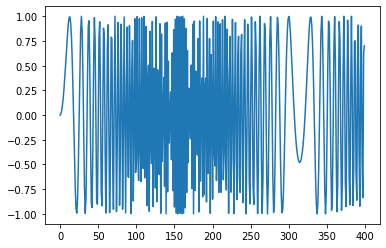

In [3]:
plt.plot(series)
plt.show()

In [4]:
T = 10
D = 1
X = []
Y = []
for t in range (len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)   # Sequence length X batch size X input size   (390, 10, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)  

X.shape (390, 10, 1) Y.shape (390, 1)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size =self.M,
        num_layers=self.L,
        batch_first=True        #Without batch_first=True it will use the first dimension as the sequence dimension.
                                #With batch_first=True it will use the second dimension as the sequence dimension.
    )

                                #If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
    self.fc = nn.Linear(self.M, self.K)

                               #In the forward function, you define how your model is going to be run, from input to output
                               #The forward function defines how to get the output of the neural net. In particular, it is called when you apply the neural net to an input Variable:

  def forward(self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)  #output is of size (N, T, M)
    out, _ = self.rnn(X, h0)                                #ignore second return value i.e. hidden states at each hidden layer 
    out = self.fc(out[:, -1, :])
    return out 

In [7]:
model = RNN(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model.to(device)

RNN(
  (rnn): RNN(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [9]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [10]:
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):
  
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):

    # SPECIFY INITIAL STATE OF GRADIENT
    optimizer.zero_grad()
    # PASS THE INPUT TO THE MODEL
    outputs = model(X_train)
    #COMPUTING THE TRAIN LOSS
    loss = criterion(outputs, y_train)
    # STORES GRADIENT AND ADJUSTS ACC. TO OPTIMIZER
    loss.backward()
    optimizer.step()
    # SAVE LOSSES
    train_losses[it] = loss.item()
    # COMPUTING THE TEST LOSS
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it):
      print(f"Epoch: {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
  return train_losses, test_losses

In [11]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [12]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)


Epoch: 2/200, Train Loss: 0.6908, Test Loss: 0.5225
Epoch: 3/200, Train Loss: 0.5120, Test Loss: 0.5630
Epoch: 4/200, Train Loss: 0.5113, Test Loss: 0.6118
Epoch: 5/200, Train Loss: 0.5284, Test Loss: 0.6342
Epoch: 6/200, Train Loss: 0.5262, Test Loss: 0.6395
Epoch: 7/200, Train Loss: 0.5162, Test Loss: 0.6378
Epoch: 8/200, Train Loss: 0.5055, Test Loss: 0.6346
Epoch: 9/200, Train Loss: 0.4939, Test Loss: 0.6331
Epoch: 10/200, Train Loss: 0.4889, Test Loss: 0.6311
Epoch: 11/200, Train Loss: 0.4880, Test Loss: 0.6215
Epoch: 12/200, Train Loss: 0.4811, Test Loss: 0.6066
Epoch: 13/200, Train Loss: 0.4691, Test Loss: 0.6002
Epoch: 14/200, Train Loss: 0.4633, Test Loss: 0.5974
Epoch: 15/200, Train Loss: 0.4629, Test Loss: 0.5868
Epoch: 16/200, Train Loss: 0.4531, Test Loss: 0.5768
Epoch: 17/200, Train Loss: 0.4449, Test Loss: 0.5759
Epoch: 18/200, Train Loss: 0.4383, Test Loss: 0.5853
Epoch: 19/200, Train Loss: 0.4284, Test Loss: 0.6005
Epoch: 20/200, Train Loss: 0.4199, Test Loss: 0.6150
E

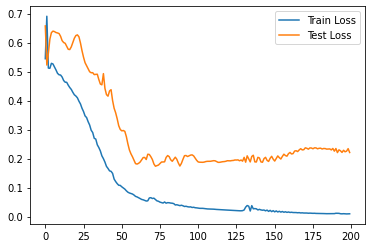

In [13]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

In [14]:
#predicting future values
#X contains past values and Y contains future values
validation_target = Y[-N//2:]
validation_predictions = []

#index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].reshape(1, T, 1)
  p = model(input_)[0,0].item()       #i.e. scalar 1x1
  i += 1

  validation_predictions.append(p)

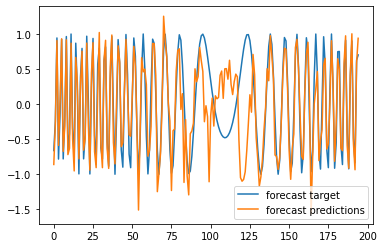

In [15]:
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast predictions")
plt.legend()
#HmmMmM pretyy gooooooOODD

In [43]:
#MULTI STEP FORECAST I.E. IT PREDICTS MULTIPLE TIME SEQUENCES ACC. TO THE ALREADY PREDICTED DATA
validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_  =last_x.reshape(1, T, 1)
  p = model(input_)
  validation_predictions.append(p[0,0].item())
  #make the new input
  last_x = torch.cat((last_x[1:], p[0]))

In [30]:
p

tensor([[1.0134]], grad_fn=<AddmmBackward>)

In [22]:
last_x

tensor([ 0.4492,  1.0134, -0.5543, -0.9836,  0.4492,  1.0134, -0.5543, -0.9836,
         0.4492,  1.0134], grad_fn=<CatBackward>)

In [31]:
last_x.reshape(1, T, 1)  #size (seq_len, batch, input_size)

tensor([[[ 0.4492],
         [ 1.0134],
         [-0.5543],
         [-0.9836],
         [ 0.4492],
         [ 1.0134],
         [-0.5543],
         [-0.9836],
         [ 0.4492],
         [ 1.0134]]], grad_fn=<ViewBackward>)

In [32]:
torch.cat((last_x[1:], p[0]))

tensor([ 1.0134, -0.5543, -0.9836,  0.4492,  1.0134, -0.5543, -0.9836,  0.4492,
         1.0134,  1.0134], grad_fn=<CatBackward>)

In [33]:
last_x.shape

torch.Size([10])

In [34]:
p[0].shape

torch.Size([1])

In [35]:
torch.cat((last_x[1:], p[0])).shape

torch.Size([10])

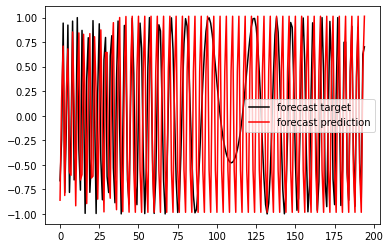

In [45]:
plt.plot(validation_target, label="forecast target", color="black")
plt.plot(validation_predictions, label="forecast prediction", color="red")
plt.legend()